# Introduction

Like the previous assignemnt, three kinds of Support Vector Classifiers will be trained to classify Shirts and Jerseys from the ImageNet database (flattened `64px x 64px` RGB images, with `64 * 64 * 128 = 12,288` dimensions each). The first will use a linear kernel, the second a polynomial kernel. We will then compare the performance of the SVCs with a deep neural network (with VGG16 as the foundation). 

 We first import all available images, resize and cohere to a format that sklearn respects,

In [53]:
shirts = glob("../18/Data/Shirt/*") # 0 
jerseys  = glob("../18/Data/Jersey/*") # 1 

In [54]:
WIDTH = 64
HEIGHT = WIDTH
DEPTH = 3
LABELS = ['jerseys', 'shirts']

# Array to hold training images
imgs = []
# Get target labels for LDA
y = []

def preprocess_clothing(dir, label):

    global imgs, y

    for img_path in dir:
        img = image.load_img(img_path, target_size=(WIDTH, HEIGHT))
        x = image.img_to_array(img)
        # Augment (size, size) to (samples, sizes, sizes)
        x = np.expand_dims(x, axis=0)
        
        imgs.append(x)
        y.append(label)

preprocess_clothing(shirts, label = 1)
preprocess_clothing(jerseys, label = 0)

imgs = np.vstack(imgs)
y = np.vstack(y)

# Complete preprocessing by flattening imgs
imgs_flat = imgs.reshape(len(imgs), WIDTH*HEIGHT*DEPTH)

# Rescale to help with optimization
scale  = StandardScaler().fit(imgs_flat)

imgs_flat = scale.transform(imgs_flat)

# Split into train/validation set
X_train, X_test, y_train, y_test = train_test_split(imgs_flat, y, test_size = 0.2)

# 2802, 12288
assert X_train.shape[0] + X_test.shape[0] == len(shirts) + len(jerseys), "Mangled Sizing"

In [5]:
# To reduce memory requirements
assert X_train.flags['C_CONTIGUOUS']

# C ~ 1/Regularization 
# Tolerance - stopping criterion 
# Check class balance
np.unique(y_train, return_counts =True)

(array([0, 1]), array([1089, 1152]))

# 3 SVCs

We have an input matrix X with size (2,802, 12,288) - a total of 2802 images. We can now initialize each SVC model and fit the model to the input data: flattened pixel data of jerseys and shirts. At the end of the section, we will briefly compare performance betweent the three. 

## Linear SVC

In [6]:
# Fit SVM model with linear kernel, default hyperparameters
start = time()
svm_linear = svm.LinearSVC()
svm_linear.fit(X_train, y_train.ravel())
stop = time()
training_time = round(stop - start, 2)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Test Accuracy Score: 0.5668449197860963 
 Train Accuracy Score: 0.9767960731816153 
 Training Time: 56.27s


<Figure size 360x360 with 0 Axes>

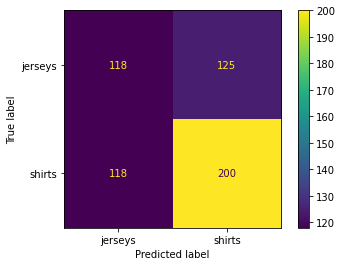

In [14]:
# Score linear kernel and show training time
print(
    "Test Accuracy Score:",  accuracy_score(y_test.ravel(), svm_linear.predict(X_test)), '\n',
    "Train Accuracy Score:", accuracy_score(y_train.ravel(), svm_linear.predict(X_train)), '\n',
    "Training Time:", f'{training_time}s'
)

# Show confusion matrix for test set
show_cm(y_test, svm_linear, X_test)

## Polynomial SVC

In [15]:
# Fit SVM model with polynomial kernel, default hyperparameters
start = time()
svm_poly = svm.SVC(
    kernel = 'poly'
)
svm_poly.fit(X_train, y_train.ravel())
stop = time()

training_time = round(stop - start, 2)

svm_poly.get_params()['degree']

Test Accuracy Score: 0.6363636363636364 
 Train Accuracy Score: 0.8473895582329317 
 Training Time: 17.56s


<Figure size 360x360 with 0 Axes>

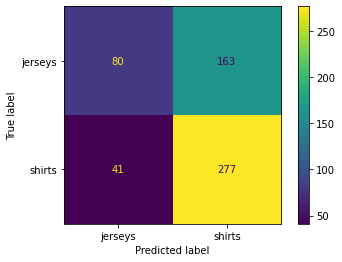

In [17]:
# Score poly kernel and show training time
print(
    "Test Accuracy Score:",  accuracy_score(y_test.ravel(), svm_poly.predict(X_test)), '\n',
    "Train Accuracy Score:", accuracy_score(y_train.ravel(), svm_poly.predict(X_train)), '\n',
    "Training Time:", f'{training_time}s'
)

# Show confusion matrix for test set
show_cm(y_test, svm_poly, X_test)

## RBF SVC 

In [18]:
# Fit SVM model with rbf kernel, default hyperparameters
start = time()
svm_rbf = svm.SVC(
    kernel = 'rbf'
)
svm_rbf.fit(X_train, y_train.ravel())
stop = time()

training_time = round(stop - start, 2)

Test Accuracy Score: 0.6470588235294118 
 Train Accuracy Score: 0.8447121820615796 
 Training Time: 18.18s


<Figure size 360x360 with 0 Axes>

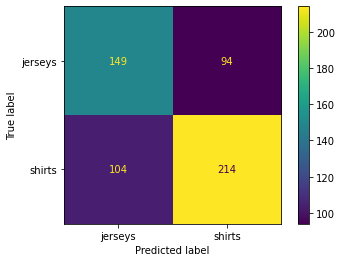

In [19]:
# Score poly kernel and show training time
print(
    "Test Accuracy Score:",  accuracy_score(y_test.ravel(), svm_rbf.predict(X_test)), '\n',
    "Train Accuracy Score:", accuracy_score(y_train.ravel(), svm_rbf.predict(X_train)), '\n',
    "Training Time:", f'{training_time}s'
)

# Show confusion matrix for test set
show_cm(y_test, svm_rbf, X_test)

Based on test set accuracy, the RBF kernel performs best with 64.7%, followed closely by the polynomial kernel (degree 3) with 63.6%, and tailed finally by the basic linear kernel with 56.6%. This ranking is reversed based on training set accuracy (Linear: 97.6%, Poly: 84.7%, RBF: 84.4%), indicating that the degree to which each model is overfit decreases with the degree of flexibility of the kernel representation. 

If each layer of a neural network can be thought of a transformation of input representation, we can wager that its performance will be better than the SVCs so far. 


# Neural Network

The design of this network is straightforward. Take the VGG16 deep neural network, with ImageNet weights, remove the top layer, add a couple of Dense relu activation layers and a prediction (sigmoid) layer. 

In the interest of making fair comparisons, image dimensions were held constant between SVCs and the Neural Network. 

(Note: I received help from Nikita regarding preprocessing, and general intuitions about how to put this together. I still think this is a vague kind of magic.)


In [56]:
# Same thing as before, albeit in a format tf likes: two iterators
base_dir = '../18/Data'

# Perform same steps as before
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2)

batch = 10
train_gen = data_gen.flow_from_directory(
    base_dir,
    target_size=(WIDTH, HEIGHT),
    class_mode="binary",
    batch_size=batch,
    subset = "training")

validation_gen = data_gen.flow_from_directory(
    base_dir,
    target_size=(W, H),
    class_mode="binary",
    batch_size=10,
    subset = "validation")

assert sum(y) == sum(np.concatenate((train_gen.classes, validation_gen.classes)))

Found 2242 images belonging to 2 classes.
Found 560 images belonging to 2 classes.


In [61]:
# Clip its beak for transfer learning
vgg = VGG16(
    weights='imagenet', 
    include_top = False,
    input_shape = (WIDTH,HEIGHT,DEPTH) )
vgg.trainable = False

model = Sequential([
    vgg,
    layers.Conv2D(32,3, activation = 'relu', padding = 'same'),
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(1024, activation = 'relu'),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ['accuracy'])

model.summary()

fit_model = model.fit(
    train_gen,
    epochs = 10,
    validation_data = validation_gen
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 32)          147488    
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1024)              33792     
                                                                 
 dense_9 (Dense)             (None, 256)               262400    
                                                      

In [92]:
max(fit_model.history['val_accuracy'])

0.7857142686843872

The neural network begins with the VGG16 model, pretrained on the ImageNet database (which is to say, we inherit its weights and transformation layers: its prior learnings about image patterns). We then drop the top layer, as we want to introduce a specific binary classification between jerseys and shirts. 

To learn the specific features that discern jerseys and shirts, a convolution layer is added, with a following Global Average Pooling layer to extract these features. The image is then flattened prior to becoming inputs to two Dense layers. Finally, a sigmoid function outputs the probability of the image belonging to the '1' class, which happens to be Jerseys here. 

Binary cross entropy is the loss function, as we have a binary classification problem, and its derivate is easy to compute during backprop. Additionally, when we reduce crossentropy, we are maximizing MLE, which is what we desire in fitting the model. 

At the end of epoch 3, the neural network achieves a test accuracy of about 78.5%!

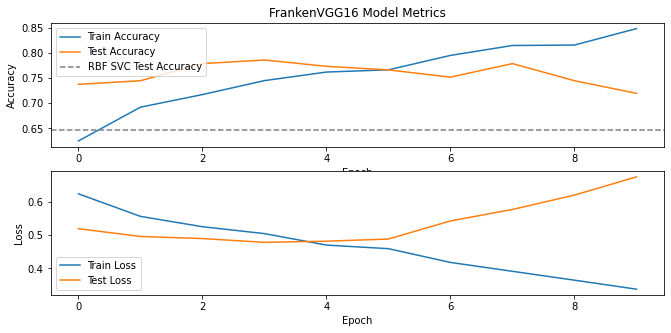

In [87]:
fig, axs = plt.subplots(2,1, figsize = (11,5))

axs[0].plot(
    fit_model.history['accuracy'],
    label = "Train Accuracy")

axs[0].plot(
    fit_model.history['val_accuracy'],
    label = "Test Accuracy"
)
axs[0].axhline(
    0.647, 
    label = "RBF SVC Test Accuracy",
    linestyle = '--',
    color = "grey"
    )
axs[0].set_title("FrankenVGG16 Model Metrics")
axs[0].legend(loc = 'upper left')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")


axs[1].plot(
    fit_model.history['loss'],
    label = "Train Loss")

axs[1].plot(
    fit_model.history['val_loss'],
    label = "Test Loss"
)

axs[1].legend()
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
plt.show()

The plot above describes the changes in accuracy over training epochs of the neural network. Training accuracy increases monotonically with the monotonic decrease in training loss (as expected), though the improvements in test accuracy halt at epoch 3 (about 78.5%) and the neural network becomes overfit. 

Nonetheless, it significantly outperforms the best SVC (at about 65% on the test set) across all epochs. The incredible flexibility of neural networks over SVCs have led to impressive gains in classification accuracy.

# Technical Appendix

In [26]:
## Imports
from glob import glob
import numpy as np 

import pandas as pd

from time import time
import scipy.stats as sts

from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Sequential

import tensorflow as tf

In [12]:
## Plotting/ Misc Functions (run first)

def plot_paramsearch(clf):
    results = pd.DataFrame(clf.cv_results_)
    param_results = results.groupby('param_C').mean()

    fig = plt.figure(figsize=(9,3), tight_layout = True)

    plt.subplot(121)
    ax = param_results["mean_fit_time"].plot(label = "PCA SVM")

    ax.fill_between(
        param_results.index,
        param_results["mean_fit_time"] + param_results["std_fit_time"],
        param_results["mean_fit_time"] - param_results["std_fit_time"],
        alpha = 0.1,
        color = "blue"
    )

    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_ylabel("Training Time (s)")

    #ax.semilogx(C, training_time, label = "Basic SVM")
    ax.legend()

    plt.subplot(122)

    ax2 = param_results['mean_test_score'].plot(label = "PCA SVM")
    ax2.fill_between(
        param_results.index,
        param_results["mean_test_score"] + param_results["std_test_score"],
        param_results["mean_test_score"] - param_results["std_test_score"],
        alpha = 0.1,
        color = "blue"
    )
    ax2.set_xscale('log')
    ax2.set_ylabel("Training Accuracy")

    plt.show()

def show_cm(y, model, x):
    plt.figure(figsize=(5,5))
    cm = confusion_matrix(y, model.predict(x))

    return ConfusionMatrixDisplay(
        confusion_matrix = cm,
        display_labels=LABELS).plot()
    
